In [ ]:
#!nvidia-smi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11387715722162769601, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2776797773325638066
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir="/content/drive/My Drive/Module 2 Material/kaggle2/"
print(dir)
train_dir=os.path.join(dir,'train')
test_dir=os.path.join(dir,'experiment')
val_dir=os.path.join(dir,'valid')

/content/drive/My Drive/Module 2 Material/kaggle2/


In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat))
    print('\33[0m') # returns default print color to back to black
    return

In [ ]:
classes=os.listdir(train_dir) # class names are the names of the sub directories
class_count=len(classes) # determine number of classes
batch_size=56 # set training batch size
rand_seed=123
start_epoch=0 # specify starting epoch
epochs=30 # specify the number of epochs to run
img_size=224 # use 224 X 224 images compatible with mobilenet model
lr=.001 # specify initial learning rate

In [ ]:
def get_bs(dir,b_max):
    # dir is the directory containing the samples, b_max is maximum batch size to allow based on your memory capacity
    # you only want to go through test and validation set once per epoch this function determines needed batch size ans steps per epoch
    length=0
    dir_list=os.listdir(dir)
    for d in dir_list:
        d_path=os.path.join (dir,d)
        length=length + len(os.listdir(d_path))
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]
    return batch_size,int(length/batch_size)

In [ ]:
valid_batch_size, valid_steps=get_bs(val_dir, 100)
test_batch_size, test_steps=get_bs(test_dir,100)

In [ ]:
train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, horizontal_flip=True).flow_from_directory(
        train_dir,  target_size=(img_size, img_size), batch_size=batch_size, seed=rand_seed, class_mode='categorical', color_mode='rgb')

valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) .flow_from_directory(val_dir,
                    target_size=(img_size, img_size), batch_size=valid_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False)
test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_dir,
                    target_size=(img_size, img_size), batch_size=test_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False )
test_file_names=test_gen.filenames  # save list of test files names to be used later
test_labels=test_gen.labels # save test labels to be used later

val_file_names=valid_gen.filenames  # save list of test files names to be used later
val_labels=valid_gen.labels # save test labels to be used later

Found 2536 images belonging to 2 classes.
Found 197 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


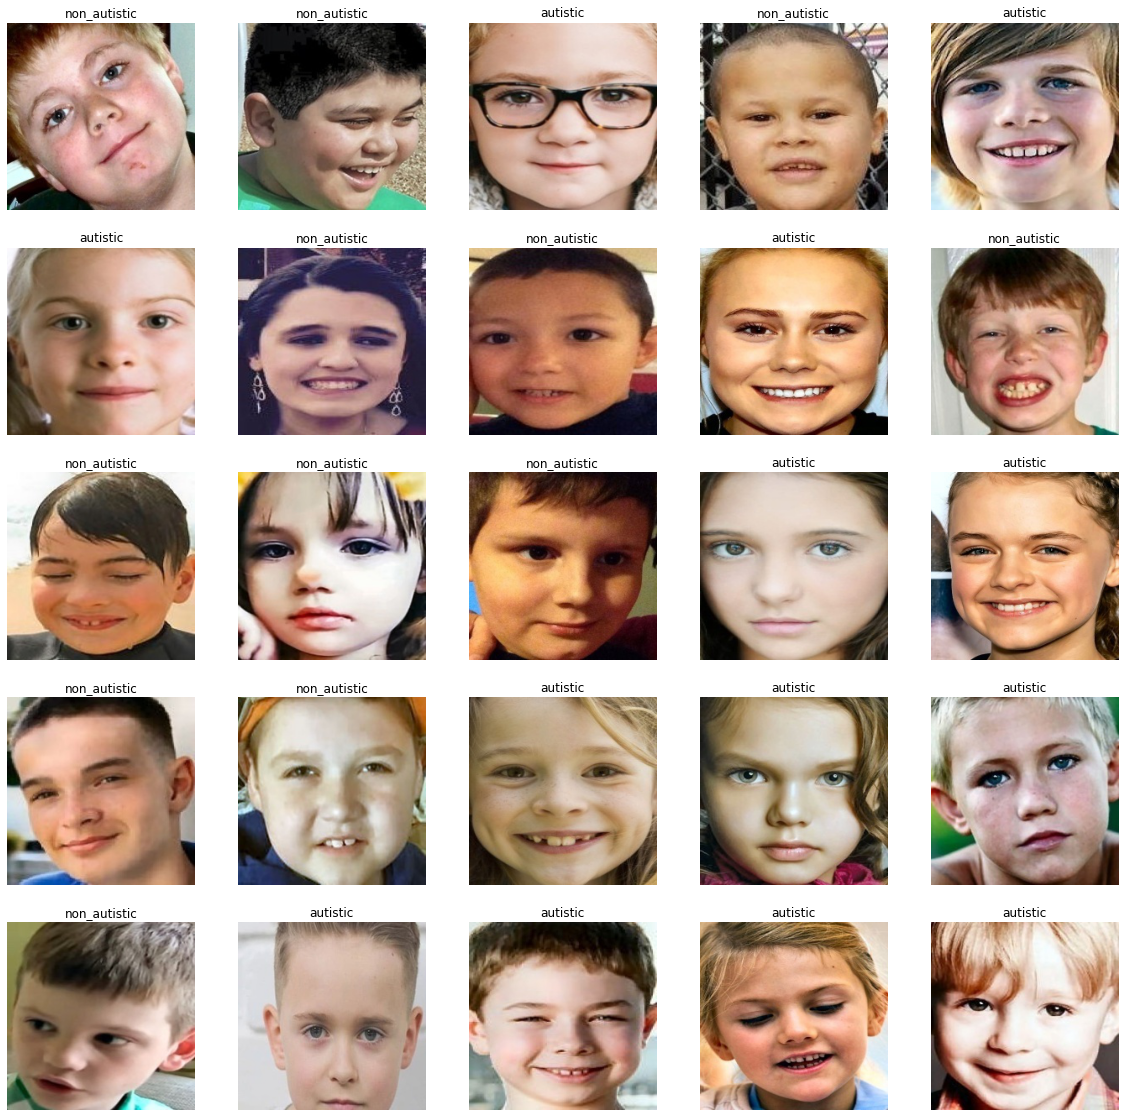

In [ ]:
images,labels=next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image=(images[i]+1 )/2
    plt.imshow(image)
    index=int(labels[i][1])
    plt.title(classes[index], color='black')
    plt.axis('off')
plt.show()

In [ ]:
_model = tf.keras.applications.densenet.DenseNet201( include_top=False, input_shape=(img_size, img_size,3), pooling='max', weights='imagenet')
_model.trainable=False
x=_model.layers[-1].output # this is the last layer in the mobilenet model the global max pooling layer
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(128, activation='relu')(x)
x=Dropout(rate=.4, seed = 123)(x)
predictions=Dense (len(classes), activation='softmax')(x)
model = Model(inputs=_model.input, outputs=predictions)
for layer in model.layers:
    layer.trainable=True
model.compile(Adamax(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
class LRA(keras.callbacks.Callback):
    best_weights=model.get_weights() # set a class vaiable so weights can be loaded after training is completed
    def __init__(self, patience=2, threshold=.95, factor=.5):
        super(LRA, self).__init__()
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        self.count=0
        msg='\n Starting Training - Initializing Custom Callback'
        print_in_color (msg, (244, 252, 3), (55,65,80))

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                msg= f'\n training accuracy improved from  {self.highest_tracc:7.2f} to {acc:7.2f} learning rate held at {lr:9.6f}'
                print_in_color(msg, (0,255,0), (55,65,80))
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=model.get_weights() # traing accuracy improved so save the weights
                count=0 # set count to 0 since training accuracy improved
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
            else:  # training accuracy did not improve check if this has happened for patience number of epochs if so adjust learning rate
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    if v_loss<self.lowest_vloss:
                        self.lowest_vloss=v_loss
                    msg=f'\nfor epoch {epoch +1} training accuracy did not improve for {self.patience } consecutive epochs, learning rate adjusted to {lr:9.6f}'
                    print_in_color(msg, (255,0,0), (55,65,80))
                else:
                    self.count=self.count +1
                    msg=f'\nfor  epoch {epoch +1} training accuracy did not improve, patience count incremented to {self.count}'
                    print_in_color(msg, (255,255,0), (55,65,80))
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                msg=f'\n for epoch {epoch+1} validation loss improved from  {self.lowest_vloss:7.4f} to {v_loss:7.4}, saving best weights'
                print_in_color(msg, (0,255,0), (55,65,80))
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor
                    msg=f' \nfor epoch {epoch+1} validation loss failed to improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:9.6f}'
                    self.count=0 # reset counter
                    print_in_color(msg, (255,0,0), (55,65,80))
                    tf.keras.backend.set_value(model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                else:
                    self.count =self.count +1 # increment the count
                    msg=f' \nfor epoch {epoch+1} validation loss did not improve patience count incremented to {self.count}'
                    print_in_color(msg, (255,255,0), (55,65,80))

In [ ]:
def tr_plot(tr_data):
    #Plot the training and validation data
    history=tr_data.history
    tacc=results.history['accuracy']
    tloss=results.history['loss']
    vacc=results.history['val_accuracy']
    vloss=results.history['val_loss']
    Epoch_count=len(tloss)
    Epochs=[]
    for i in range (0,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    val_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
# callbacks=[LRA()]
# results=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=test_gen,
#                validation_steps=test_steps,  shuffle=True,  initial_epoch=start_epoch)

In [ ]:
# tr_plot(results)

In [ ]:
# Save the model to use later
import keras
from keras.models import model_from_json
fer_json = model.to_json()

with open("/content/drive/MyDrive/Module 2 Material/densenet.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("/content/drive/MyDrive/Module 2 Material/densenet.h5")
# load json and create model
json_file = open('/content/drive/MyDrive/Module 2 Material/densenet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Module 2 Material/densenet.h5")
print("Loaded model from disk")

# # Evaluate the model on the test data using `evaluate`
# loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# score = loaded_model.evaluate(real_X_test, real_test_y, batch_size=batch_size)

# print("Evaluate on test data")
# results = model.evaluate(real_X_test, real_test_y, batch_size=batch_size)
# print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(real_X_test[:3])
# print("predictions shape:", predictions.shape)

Loaded model from disk


In [ ]:
model.set_weights(LRA.best_weights)
acc_val=model.evaluate( valid_gen, batch_size=valid_batch_size, verbose=1, steps=valid_steps)[1]* 100
msg_val=f'accuracy on the test set is {acc_val:5.2f} %'
print_in_color(msg_val, (0,255,0),(55,65,80))

197/197 [==============================] - 5s 24ms/step - loss: 1.7630 - accuracy: 0.5228
accuracy on the test set is 52.28 %



In [ ]:
#Logistic Regression
import os
import sys
dir="/content/drive/My Drive/Hybrid Model/CSEF"
sys.path.append(dir)
print(dir)
from processing import ADOS_Data

/content/drive/My Drive/Hybrid Model/CSEF


In [ ]:
from cross_validation import CVP_Set
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from classifiers import RegClassifier, BinClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, precision_recall_curve, auc

import matplotlib.pyplot as plt
import pandas as pd

def test_func(pred_score, predlabels, name='lr5'):
    y_true = [int(v!=0) for v in list(predlabels)]
    print('Confusion matrix:')
    cm = confusion_matrix([1-x for x in y_true], [1-int(x > 0.5) for x in pred_score])
    print([int(x > 0.5) for x in pred_score])
    print(cm)
    print('Precision: {}'.format(float(cm[0][0])/(cm[0][0]+cm[1][0])))
    print('Recall/Sensitivity: {}'.format(float(cm[0][0])/(cm[0][0]+cm[0][1])))
    print('Specificity: {}'.format(float(cm[1][1])/(cm[1][1]+cm[1][0])))
    print ('class report')
    print (classification_report([1-x for x in y_true], [1-int(x > 0.5) for x in pred_score]))

################### data loading ###############
MODULE = 'm2'
FEATURE_SET = ['A3', 'A5', 'B1', 'B2', 'B10']
N_FOLD = 10
PRED_RATIO = 0.2
SCALING_PARAM = 4
# Binary or Replacement
MISSING_VALUE_STRATEGY = 'Binary'
# poly, linear, indicator, interaction_ind, pca_comp
PROCESSING_STRATEGY = 'linear'

POLY_DEGREE = 2
NORMALIZE = True

ADOS_FILE = ADOS_FILE = dir + ("/ados_m2_allData.csv")
label_id = "ASD"
label_age = "age_months"
label_gender = "male"
columns_to_delete = ["Subject.Id", "Diagnosis"]
sub_diagnosis_id = ["social_affect_calc","restricted_repetitive_calc","SA_RRI_total_calc","severity_calc"]

# We import the code
data = ADOS_Data.read_csv(ADOS_FILE)
sub_diagnosis = data[sub_diagnosis_id]

# We drop the columns that are not interesting for us, and the row with no label
data.select_good_columns(columns_to_delete+sub_diagnosis_id)

print('gendering')
print((data[data['ASD'] == 1][['male']]).sum())


data.full_preprocessing(NORMALIZE, MISSING_VALUE_STRATEGY, PROCESSING_STRATEGY, [label_age], label_gender, label_id)

'''
we are only training on the 5 features above (doing the "select good columns")
['A3', 'A5', 'B1', 'B2', 'B10'], very likely that's why the training runs very fast
'''

print(data.shape)
if FEATURE_SET != []:
    data.select_good_columns(FEATURE_SET, keep_the_column=True)
    data[:]=data[FEATURE_SET]
cv_set = CVP_Set(data, data.labels, N_FOLD, PRED_RATIO)

'''
this is the binary classifier the author use. this is calling the LogisticRegression from sklearn, but then make it discrete.
i.e. from any number in 0 ~ 1(0.01, 0.8...) -> only category(categories) we are looking for, in this case just 0 and 1
'''
lr = BinClassifier(proc=LogisticRegression(C=0.045, penalty='l2',class_weight='balanced'), severity=True)
lr.fit(cv_set.cv_feat, cv_set.cv_labels)




''' this file actually located in the same diretory as the RUNME_L5.ipynb. Please lemme know if you still got failure on this run'''
FILENAME = dir + ("/newvideodataset.csv")
columns_to_delete = ['child_id','scorer_id','video_file']
pred_feat = ADOS_Data.read_csv(FILENAME,skip_blank_lines=True)
pred_feat = pred_feat[0:19]
pred_feat = ADOS_Data(pred_feat)
ytrue = pred_feat["ASD"]
# We drop the columns that are not interesting for us, and the row with no label
pred_feat.select_good_columns(columns_to_delete)
#print(pred_feat)
print("DATA")
print(pred_feat["A3"])




pred_feat.full_preprocessing(NORMALIZE, MISSING_VALUE_STRATEGY, PROCESSING_STRATEGY, [label_age], label_gender, label_id)
if FEATURE_SET != []:
    pred_feat.select_good_columns(FEATURE_SET, keep_the_column=True)
    '''  pred_feat[:]=pred_feat[FEATURE_SET]'''
print("=====starting here is the result on this model======")
#print(pred_feat)
test_func(list(lr.predict(pred_feat)), ytrue)
print(list(lr.predict(pred_feat)))

svc = BinClassifier(proc = SVC(C = 1), severity = False)
svc.fit(cv_set.cv_feat, cv_set.cv_labels)
svc_dec_vals = svc.decision_function(pred_feat)

''' optional of printing this to see prediction details '''
'''
print("---Printing probabilities of each input patient's chance of ASD---")
print("you can always just get this result, and simply classify yes/no ADS comparing the probability with 0.5")
LogisticProbabilities = (lr.predict_proba(pred_feat))
for line in LogisticProbabilities:
    print(line)
print("---End of Printing Probabilities---")
print("total number of result here is the same as the testing file : ", len(LogisticProbabilities))


l = list(zip(LogisticProbabilities, list(lr.predict(pred_feat))))
with open('results_lr_5.csv', 'w') as f:
    for i in range(len(l)):
        f.write(str(l[i])+'\n') '''
print('svc')
test_func(svc_dec_vals, ytrue, 'SVC')

#weighted average
result1 = svc_dec_vals
minval = result1.min()
maxval = result1.max()
result1 = (result1-minval)/(maxval-minval)
print(result1)

hello!
      A1   A2  A3  A4  A5  A6  A7  ...  D4  E1  E2  E3  age_months  male  ASD
0      0  1.0   2   0   1   2   0  ...   3   0   1   2        65.0     1    2
1      1  0.0   1   2   1   1   0  ...   1   1   0   1        36.0     0    2
2      1  2.0   2   1   2   2   2  ...   2   1   2   2        58.0     0    2
3      0  1.0   1   0   1   2   0  ...   1   0   1   1        49.0     1    2
4      1  0.0   1   2   2   2   0  ...   1   1   0   1        49.0     0    2
...   ..  ...  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..         ...   ...  ...
1384   0  0.0   2   2   2   2   0  ...   2   0   0   0       107.0     0    2
1385   1  2.0   2   2   1   2   1  ...   2   0   0   0        79.0     1    2
1386   0  1.0   2   2   2   2   1  ...   2   1   0   0        60.0     0    2
1387   0  1.0   2   1   2   1   0  ...   2   1   0   0        81.0     1    2
1388   0  1.0   1   1   0   1   0  ...   1   0   0   0        62.0     1    1

[1389 rows x 31 columns]
gendering
male    163
dtype: in

/content/drive/My Drive/Hybrid Model/CSEF/processing.py:76: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.labels = self[label_id]
/content/drive/My Drive/Hybrid Model/CSEF/processing.py:76: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.labels = self[label_id]


     updatedAt  question_set   A3   A5  B10  question3  question4  question5  \
8.0        NaN           NaN  1.0  1.0    1        NaN        NaN        NaN   
9.0        NaN           NaN  NaN  2.0    3        NaN        NaN        NaN   

     question6  question7  B1  question9  question10  question11  question12  \
8.0        NaN        NaN   1        NaN         NaN         NaN         NaN   
9.0        NaN        NaN   5        NaN         NaN         NaN         NaN   

     question13  question14  B2  question16  question17  question18  \
8.0         NaN         NaN   1         NaN         NaN         NaN   
9.0         NaN         NaN   4         NaN         NaN         NaN   

     question19  question20  question21  question22  question23  question24  \
8.0         NaN         NaN         NaN         NaN         NaN         NaN   
9.0         NaN         NaN         NaN         NaN         NaN         NaN   

     question25  question26  question27  question28  question29  q

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(valid_gen, batch_size=64, verbose = 1)
y_pred_bool = np.argmax(y_pred, axis = 1)
print(classification_report(val_labels, y_pred_bool))
print(y_pred_bool)
print(y_pred[:,1])
y_result = y_pred[:,1]
framecount = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #update based on number of images per each video
start = 0
result2 = []
for i in range(len(framecount)):
  end = start + framecount[i]
  sum = 0
  for j in range(framecount[i]):
    sum += float(y_result[start+j])
  result2.append(sum / framecount[i])
  start = end
result2 = np.asarray(result2)
print(result2)
#print(y_pred)

197/197 [==============================] - 4s 22ms/step
              precision    recall  f1-score   support

           0       0.98      0.37      0.53       147
           1       0.35      0.98      0.51        50

    accuracy                           0.52       197
   macro avg       0.66      0.67      0.52       197
weighted avg       0.82      0.52      0.53       197

[1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[9.77056921e-01 9.51442957e-01 9.37738359e-01 6.05705261e-01
 9.83748317e-01 3.16382647e-01 9.96792018e-01 8.82785559e-01
 9.98777807e-01 2.65124202e-01 9.93514538e-01 9.87920880e-01
 9.83406425e-01 9.97823715e-01 8.

In [ ]:
final_result = result1*0.42451299
final_result += result2*0.57548701
print(final_result)

[0.95176175 0.95176175 0.95126061 0.9593031  0.95176175 0.37627477
 0.95176175 0.95176175 0.95176175 0.42451299 0.57548701 0.57548701
 0.57548701 0.57548701 0.9520013  0.95176175 0.98877467 0.95176186
 0.96445859]


In [ ]:
from sklearn.metrics import classification_report
final_result_bool = (final_result > .5)
val_result = val_labels
#framecount = [1,2,3,4,5,6,7,8,9,1,1,2,3,4,5,6,7,8,9] #update based on number of images per each video
start = 0
val_labels1 = []
for i in range(len(framecount)):
  end = start + framecount[i]
  sum = 0
  for j in range(framecount[i]):
    sum += float(val_result[start+j])
  np.append(result2, sum / framecount[i])
  start = end
result2 = np.asarray(result2)
# for i in range(result2.size):
#   result2[i] = int(result2[i] + 0.5)
# print(result2)
#val_labels1 = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
print(classification_report(val_labels1, final_result_bool))
#print(classification_report(result2, final_result_bool))
print(final_result_bool)

[1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.89      1.00      0.94        17

    accuracy                           0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# #convert videos to images
# import cv2
# import os
# from os import listdir
# from os.path import isfile, join

# in_path = "/content/drive/My Drive/Clips_Autism/"
# out_path = "/content/drive/My Drive/Clips_Autism/Test_Autism"
# frame_rate = 100
# if(os.path.isdir(out_path) == False):
# 	os.mkdir(out_path)
# else:
# 	print("There is a test folder existing, to avoid overlap images, please backup/remove this folder.")
# 	exit()

# files = [f for f in listdir(in_path) if isfile(join(in_path, f))]
# print("found the following files: \n %s" % files)

# for file in files[0]:
# 	vidcap = cv2.VideoCapture(join(in_path, file)) i wanna be the very best at pokemon go because.. in real life, my life's a mess, and this game gives me a cause...I will travel across the lanes, i almost hit that guy, but its
# 	frame_base_name = file[:-4]
# 	print("processing %s " % frame_base_name)
# 	success,image = vidcap.read()
# 	count = 0
# 	while success:
# 		frame_name = frame_base_name + '_' + str(count)
# 		if count % frame_rate == 0:
# 			resize_image = cv2.resize(image, (224, 224))
# 			cv2.imwrite("%s.jpg" % join(out_path, frame_name), resize_image)     # save frame as JPEG file
# 			print('Read a new frame for %s : ' % (frame_name), success)
# 		success,image = vidcap.read()
# 		count += 1
